# Programmer un réseau de neurones à 2 couches

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from tqdm import tqdm

## Démarche de conception :
- Définition de la classe:
    - Concevoir un réseau de neurones multicouches avec possible `vashining gradient`. On y remédiera en utilisant un autre type de fonction d'activation (RELU OU SOFTRELU).
    - Entrées :
        - hidden_layers : un dictionnaire qui définit le nombre de noeuds de chaque couche. Exemple :
        {"hidden_layers": [`nombre_couche1`, `nombre_couche2`, ...]}. 
        - learning_rate : Le taux d'apprentissage de la descente de gradient. Plus il est élevé, plus rapidement les estimateurs des paramètres convergent.
        Attention à ne pas donner un taux d'apprentissage trop élevé ou trop faible (cause de la convergence des estimateurs).
        - epochs : Le nombre d'itérations.
    - Paramètres supplémentaires non visibles (La taille de ces paramètres peut varier suivant le nombre de hidden layers et leurs tailles) :
        - parametres : Contient les poids et les biais des différentes couches. Peut être transformer lors de la descente de gradient.
        -  

In [101]:
class NeuralNetwork:
    """Un réseau de neurone multicouche
    params:
        n1 (int): Le nombre de neurones de la oremière couche.
        learning_rate (float): Le taux d'apprentissage de la descente de gradient. Plus il est élevé, plus rapidement les estimateurs des paramètres convergent.
        Attention à ne pas donner un taux d'apprentissage trop élevé ou trop faible (cause de la convergence des estimateurs).
        epochs (float): Le nombre d'itérations. 
    """
    def __init__(self, n1, learning_rate = 0.1, epochs = 1000):
        self.n1 = n1
        self.learning_rate = learning_rate
        self.epochs = epochs
    
    def initialisation(self, n0, n1, n2):
        W1 = np.random.randn(n1, n0)
        b1 = np.random.randn(n1, 1)
        W2 = np.random.randn(n2, n1)
        b2 = np.random.randn(n2, 1)
        
        self.parametres = {
            'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2
        }
    
    def forward_propagation(self, X):
        W1 = self.parametres['W1']
        b1 = self.parametres['b1']
        W2 = self.parametres['W2']
        b2 = self.parametres['b2']
        
        Z1 = W1.dot(X) + b1
        A1 = 1 / (1 + np.exp(-Z1))
        Z2 = W2.dot(A1) + b2
        A2 = 1 / (1 + np.exp(-Z2))
        
        self.activations = {
            'A1': A1,
            'A2': A2
        }
    
    def back_propagation(self, X, y):
        A1 = self.activations['A1']
        A2 = self.activations['A2']
        W2 = self.parametres['W2']
        
        m = y.shape[1]
        
        dZ2 = A2 - y
        dW2 = 1 / m * dZ2.dot(A1.T)
        db2 = 1 / m * np.sum(dZ2, axis = 1, keepdims = True)
        
        dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
        dW1 = 1 / m * dZ1.dot(X.T)
        db1 = 1 / m * np.sum(dZ1, axis = 1, keepdims = True)
        
        self.gradients = {
            'dW1' : dW1,
            'db1' : db1,
            'dW2' : dW2,
            'db2' : db2
        }
    
    def update(self):
        W1 = self.parametres['W1']
        b1 = self.parametres['b1']
        W2 = self.parametres['W2']
        b2 = self.parametres['b2']
        
        dW1 = self.gradients['dW1']
        db1 = self.gradients['db1']
        dW2 = self.gradients['dW2']
        db2 = self.gradients['db2']
        
        W1 = W1 - self.learning_rate * dW1
        b1 = b1 - self.learning_rate * db1
        W2 = W2 - self.learning_rate * dW2
        b2 = b2 - self.learning_rate * db2
        
        self.parametres = {
            'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2
        }
    
    def predict(self, X_test):
        self.forward_propagation(X_test)
        A2 = self.activations['A2']
        return A2 >= 0.5
    
    def log_loss(self, y_train):
        A2 = self.activations['A2']
        m = y_train.shape[1]
        epsilon = 1e-15
        return 1 / m * np.sum(-y * np.log(A2+epsilon) - (1 - y) * np.log(1 - A2 +epsilon))
    
    def fit(self, X_train, y_train):
        #initialisation w, b
        n0 = X_train.shape[0]
        n2 = y_train.shape[0]
        self.initialisation(n0, self.n1, n2)
        
        train_loss = []
        train_acc = []
        for i in tqdm(range(self.epochs)):
            
            self.forward_propagation(X_train)
            self.back_propagation(X_train, y_train)
            self.update()
            
            if i % 10 ==0:
                # Train
                train_loss.append(self.log_loss(y_train))
                y_pred = self.predict(X_train)
                current_accuracy = accuracy_score(y_train.flatten(), y_pred.flatten())
                train_acc.append(current_accuracy)
        plt.figure(figsize = (14, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label = "train loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label = "train acc")
        plt.legend()
        plt.show()

## Dataset

In [96]:
plt.style.use('dark_background')
plt.rcParams['axes.grid'] = False

dimensions de X: (2, 100)
dimensions de y: (1, 100)


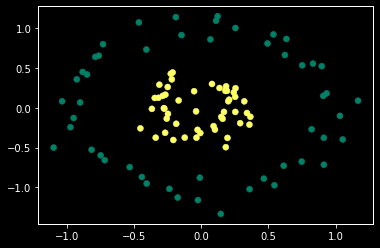

In [97]:
X, y = make_circles(n_samples=100, noise = 0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c = y, cmap = "summer")
plt.show()

In [103]:
neural_network = NeuralNetwork(2, epochs=10000, learning_rate=0.1)

100%|██████████| 10000/10000 [00:00<00:00, 13764.28it/s]


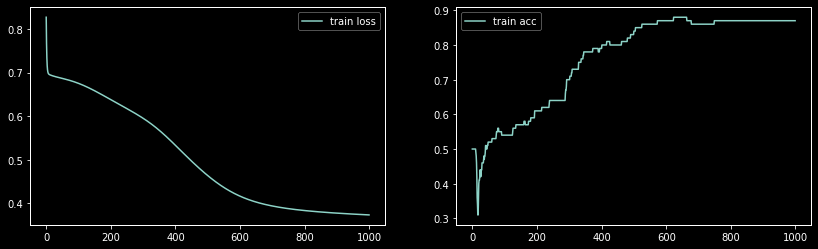

In [104]:
neural_network.fit(X, y)

In [100]:
neural_network.parametres

{'W1': array([[-7.59347414, -3.90702068],
        [-4.62700843, -8.42918252]]),
 'b1': array([[-4.9252794 ],
        [ 4.73268254]]),
 'W2': array([[-7.08652242,  6.37742308]]),
 'b2': array([[-4.63660725]])}

## Cat Vs Dog

In [90]:
from utilities import *


In [91]:
X_train, y_train, X_test, y_test = load_data()


C:\Users\Oumar Kane\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


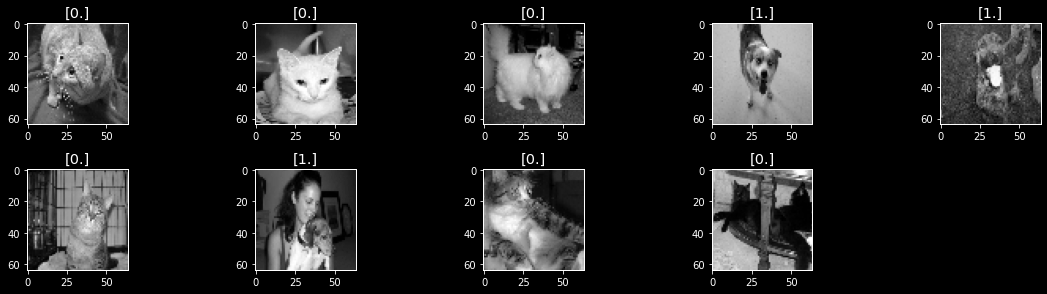

In [92]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [82]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 64, 64)
(200, 64, 64)
(1000, 1)
(200, 1)


In [83]:
y_train = y_train.T
y_test = y_test.T

In [84]:
X_train = X_train.T
X_train_reshape = X_train.reshape(-1, X_train.shape[-1])/X_train.max()

X_test = X_test.T
X_test_reshape = X_test.reshape(-1, X_test.shape[-1])/X_test.max()

m_train = 300
m_test = 80
X_test_reshape = X_test_reshape[:, :m_test]
X_train_reshape = X_train_reshape[:, :m_train]
y_train = y_train[:, :m_train]
y_test = y_test[:, :m_test]

print(X_train_reshape.shape)
print(X_test_reshape.shape)
print(y_train.shape)
print(y_test.shape)

(4096, 300)
(4096, 80)
(1, 300)
(1, 80)


In [85]:
parametres1 = neural_network(
    X_train_reshape, y_train, X_test_reshape, y_test,
    n1 = 32, learning_rate=0.01, n_iter=8000
)

  0%|          | 0/8000 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (1,100) (1,300) 